In [1]:
import ast
import pickle

import gymnasium as gym
import mlflow
import numpy as np
import pandas as pd
import torch
from imitation.algorithms.adversarial.airl import AIRL
from imitation.data.rollout import flatten_trajectories
from imitation.data.types import Trajectory
from imitation.data.wrappers import RolloutInfoWrapper
from imitation.rewards.reward_nets import BasicShapedRewardNet
from imitation.util import logger
from imitation.util.networks import RunningNorm
from imitation.util.util import make_vec_env
from stable_baselines3 import PPO
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import VecCheckNan
from stable_baselines3.ppo import MlpPolicy

import graph_reinforcement_learning_using_blockchain_data as grl
from graph_reinforcement_learning_using_blockchain_data import config

config.load_dotenv()
mlflow.set_tracking_uri(uri=config.MLFLOW_TRACKING_URI)

2025-04-11 16:23:51.257 | INFO     | graph_reinforcement_learning_using_blockchain_data.config:<module>:12 - PROJ_ROOT path is: /Users/liamtessendorf/Programming/Uni/2_Master/4_FS25_Programming/graph-reinforcement-learning-using-blockchain-data


In [2]:
RNG = np.random.default_rng(seed=42)

In [3]:
df_emb = pd.read_csv(config.FLASHBOTS_Q2_DATA_DIR / "state_embeddings.csv")
df_class0 = pd.read_csv(config.RAW_DATA_DIR / "receipts_class0.csv")
df_class1 = pd.read_csv(config.RAW_DATA_DIR / "receipts_class1.csv")
df_eth_balances_class1 = pd.read_csv(config.RAW_DATA_DIR / "eth_balances_class1.csv")
df_eth_balances_class0 = pd.read_csv(config.RAW_DATA_DIR / "eth_balances_class0.csv")

In [4]:
print(df_class0.columns)
print(df_eth_balances_class0.columns)

Index(['block_number', 'transaction_hash', 'blockHash', 'blockNumber',
       'logsBloom', 'gasUsed', 'contractAddress', 'cumulativeGasUsed',
       'transactionIndex', 'from', 'to', 'type', 'effectiveGasPrice', 'logs',
       'status'],
      dtype='object')
Index(['account', 'block_number', 'balance'], dtype='object')


In [5]:
df_class0_with_eth_balances = df_class0.merge(
    df_eth_balances_class0, left_on=["from", "blockNumber"], right_on=["account", "block_number"], how="inner"
)
df_class1_with_eth_balances = df_class1.merge(
    df_eth_balances_class1, left_on=["from", "blockNumber"], right_on=["account", "block_number"], how="inner"
)

In [6]:
df_class0_multi_occ = df_class0_with_eth_balances[
    df_class0_with_eth_balances["from"].duplicated(keep=False)
]

In [7]:
df_emb["embeddings"] = df_emb["embeddings"].apply(
    lambda x: np.array(ast.literal_eval(x), dtype=np.float32)
)

In [8]:
df_class0_with_eth_balances["label"] = 0
df_class1_with_eth_balances["label"] = 1

In [9]:
df_receipts = pd.concat([df_class0_with_eth_balances, df_class1_with_eth_balances], ignore_index=True)
df_receipts.drop_duplicates("transaction_hash", inplace=True)
df = df_receipts.merge(df_emb, how="right", left_on="transaction_hash", right_on="transactionHash")

In [10]:
df.head()

,block_number_x,transaction_hash,blockHash,blockNumber,logsBloom,gasUsed,contractAddress,cumulativeGasUsed,transactionIndex,from,...,created_at,account_address,profit_token_address,start_amount,end_amount,profit_amount,error,protocols,transactionHash,embeddings
0,16969850,0xe4029c908cfc40f825051cd0957797c66196eb8ba437...,0x241b2ebd536a6f546ce2214bcf2146d359ae4e0cc4e3...,16969850,0x00000000000000000000000000000000000000000000...,21000,NaN,1315400,19,0x00000000000124d994209fbB955E0217B5C2ECA1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0xe4029c908cfc40f825051cd0957797c66196eb8ba437...,"[-1.0455092, -0.45075172, -1.2988981, 0.689674..."
1,16975162,0xbcfb84169287cf7acce33fba2b7390cfe21852871f78...,0x577d4ef683ebd84c73cdbc3635c7177f6ec137eef3bf...,16975162,0x00000000000000000000000080000000000000000000...,116880,NaN,396290,3,0x00000000000124d994209fbB955E0217B5C2ECA1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0xbcfb84169287cf7acce33fba2b7390cfe21852871f78...,"[-6.1341934, -4.090339, -6.813894, 2.9215977, ..."
2,16983327,0x7a954e541df7c296b8fec61b77d22ea8bacd63399467...,0xe79daae4074cb858a3e79b4d95064845295eaddc134c...,16983327,0x00000000000000000000000000000000000000000000...,103421,NaN,3934866,21,0x00000000000124d994209fbB955E0217B5C2ECA1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0x7a954e541df7c296b8fec61b77d22ea8bacd63399467...,"[-5.403815, -3.6793585, -6.4153795, 2.0699742,..."
3,16990575,0x016858c7c133cdf545b6934653544c19475c5c111ba0...,0x9c3fa88c63603c9c5696174085177f9559e20b331a64...,16990575,0x00200000000000000000000080004000000000000000...,105953,NaN,4683545,39,0x00000000000124d994209fbB955E0217B5C2ECA1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0x016858c7c133cdf545b6934653544c19475c5c111ba0...,"[-7.711429, -5.4846554, -9.181214, 2.5007846, ..."
4,16994491,0x0f358c5aed8ae456a298eedaf3fc08cb802c3417a6b4...,0xae6c66f64f13ba5404bbe4cebd33fdd666c7bc8fe601...,16994491,0x00200000000011000000000080000000000000000000...,223722,NaN,3972377,34,0x00000000000124d994209fbB955E0217B5C2ECA1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0x0f358c5aed8ae456a298eedaf3fc08cb802c3417a6b4...,"[-10.870382, -8.408549, -12.329528, 6.705676, ..."


In [11]:
df_median_gas_prices = pd.DataFrame(
    {
        "median_gas_price": df.groupby(["blockNumber"])["effectiveGasPrice"].median(),
        "std_gas_price": df.groupby(["blockNumber"])["effectiveGasPrice"].std(),
        "max_gas_price": df.groupby(["blockNumber"])["effectiveGasPrice"].max(),
        "min_gas_price": df.groupby(["blockNumber"])["effectiveGasPrice"].min(),
    }
)

df_with_median_gas_prices = df.merge(df_median_gas_prices, how="left", on="blockNumber")
df_with_median_gas_prices.head()

,block_number_x,transaction_hash,blockHash,blockNumber,logsBloom,gasUsed,contractAddress,cumulativeGasUsed,transactionIndex,from,...,end_amount,profit_amount,error,protocols,transactionHash,embeddings,median_gas_price,std_gas_price,max_gas_price,min_gas_price
0,16969850,0xe4029c908cfc40f825051cd0957797c66196eb8ba437...,0x241b2ebd536a6f546ce2214bcf2146d359ae4e0cc4e3...,16969850,0x00000000000000000000000000000000000000000000...,21000,NaN,1315400,19,0x00000000000124d994209fbB955E0217B5C2ECA1,...,NaN,NaN,NaN,NaN,0xe4029c908cfc40f825051cd0957797c66196eb8ba437...,"[-1.0455092, -0.45075172, -1.2988981, 0.689674...",2.841278e+10,5.338623e+09,40046142239,27985774295
1,16975162,0xbcfb84169287cf7acce33fba2b7390cfe21852871f78...,0x577d4ef683ebd84c73cdbc3635c7177f6ec137eef3bf...,16975162,0x00000000000000000000000080000000000000000000...,116880,NaN,396290,3,0x00000000000124d994209fbB955E0217B5C2ECA1,...,NaN,NaN,NaN,NaN,0xbcfb84169287cf7acce33fba2b7390cfe21852871f78...,"[-6.1341934, -4.090339, -6.813894, 2.9215977, ...",3.132425e+10,1.310671e+10,62912040686,29651658352
2,16983327,0x7a954e541df7c296b8fec61b77d22ea8bacd63399467...,0xe79daae4074cb858a3e79b4d95064845295eaddc134c...,16983327,0x00000000000000000000000000000000000000000000...,103421,NaN,3934866,21,0x00000000000124d994209fbB955E0217B5C2ECA1,...,NaN,NaN,NaN,NaN,0x7a954e541df7c296b8fec61b77d22ea8bacd63399467...,"[-5.403815, -3.6793585, -6.4153795, 2.0699742,...",4.701599e+10,9.483538e+10,298140379626,44115991364
3,16990575,0x016858c7c133cdf545b6934653544c19475c5c111ba0...,0x9c3fa88c63603c9c5696174085177f9559e20b331a64...,16990575,0x00200000000000000000000080004000000000000000...,105953,NaN,4683545,39,0x00000000000124d994209fbB955E0217B5C2ECA1,...,NaN,NaN,NaN,NaN,0x016858c7c133cdf545b6934653544c19475c5c111ba0...,"[-7.711429, -5.4846554, -9.181214, 2.5007846, ...",3.997607e+10,2.216894e+10,72384430845,29976074199
4,16994491,0x0f358c5aed8ae456a298eedaf3fc08cb802c3417a6b4...,0xae6c66f64f13ba5404bbe4cebd33fdd666c7bc8fe601...,16994491,0x00200000000011000000000080000000000000000000...,223722,NaN,3972377,34,0x00000000000124d994209fbB955E0217B5C2ECA1,...,NaN,NaN,NaN,NaN,0x0f358c5aed8ae456a298eedaf3fc08cb802c3417a6b4...,"[-10.870382, -8.408549, -12.329528, 6.705676, ...",2.695208e+10,3.320303e+09,30915355327,22915355327


In [12]:
df_with_actions = df_with_median_gas_prices.copy()
df_with_actions["action"] = df_with_median_gas_prices.apply(
    lambda r: 1 if r["effectiveGasPrice"] > r["median_gas_price"] else 0, axis=1
)

In [13]:
df_with_actions["action"].mean()

0.24449359876667337

In [14]:
df_with_actions.head()

,block_number_x,transaction_hash,blockHash,blockNumber,logsBloom,gasUsed,contractAddress,cumulativeGasUsed,transactionIndex,from,...,profit_amount,error,protocols,transactionHash,embeddings,median_gas_price,std_gas_price,max_gas_price,min_gas_price,action
0,16969850,0xe4029c908cfc40f825051cd0957797c66196eb8ba437...,0x241b2ebd536a6f546ce2214bcf2146d359ae4e0cc4e3...,16969850,0x00000000000000000000000000000000000000000000...,21000,NaN,1315400,19,0x00000000000124d994209fbB955E0217B5C2ECA1,...,NaN,NaN,NaN,0xe4029c908cfc40f825051cd0957797c66196eb8ba437...,"[-1.0455092, -0.45075172, -1.2988981, 0.689674...",2.841278e+10,5.338623e+09,40046142239,27985774295,1
1,16975162,0xbcfb84169287cf7acce33fba2b7390cfe21852871f78...,0x577d4ef683ebd84c73cdbc3635c7177f6ec137eef3bf...,16975162,0x00000000000000000000000080000000000000000000...,116880,NaN,396290,3,0x00000000000124d994209fbB955E0217B5C2ECA1,...,NaN,NaN,NaN,0xbcfb84169287cf7acce33fba2b7390cfe21852871f78...,"[-6.1341934, -4.090339, -6.813894, 2.9215977, ...",3.132425e+10,1.310671e+10,62912040686,29651658352,1
2,16983327,0x7a954e541df7c296b8fec61b77d22ea8bacd63399467...,0xe79daae4074cb858a3e79b4d95064845295eaddc134c...,16983327,0x00000000000000000000000000000000000000000000...,103421,NaN,3934866,21,0x00000000000124d994209fbB955E0217B5C2ECA1,...,NaN,NaN,NaN,0x7a954e541df7c296b8fec61b77d22ea8bacd63399467...,"[-5.403815, -3.6793585, -6.4153795, 2.0699742,...",4.701599e+10,9.483538e+10,298140379626,44115991364,1
3,16990575,0x016858c7c133cdf545b6934653544c19475c5c111ba0...,0x9c3fa88c63603c9c5696174085177f9559e20b331a64...,16990575,0x00200000000000000000000080004000000000000000...,105953,NaN,4683545,39,0x00000000000124d994209fbB955E0217B5C2ECA1,...,NaN,NaN,NaN,0x016858c7c133cdf545b6934653544c19475c5c111ba0...,"[-7.711429, -5.4846554, -9.181214, 2.5007846, ...",3.997607e+10,2.216894e+10,72384430845,29976074199,0
4,16994491,0x0f358c5aed8ae456a298eedaf3fc08cb802c3417a6b4...,0xae6c66f64f13ba5404bbe4cebd33fdd666c7bc8fe601...,16994491,0x00200000000011000000000080000000000000000000...,223722,NaN,3972377,34,0x00000000000124d994209fbB955E0217B5C2ECA1,...,NaN,NaN,NaN,0x0f358c5aed8ae456a298eedaf3fc08cb802c3417a6b4...,"[-10.870382, -8.408549, -12.329528, 6.705676, ...",2.695208e+10,3.320303e+09,30915355327,22915355327,1


In [15]:
df_with_actions.rename(columns={"balance": "eth_balance"}, inplace=True)
df_with_actions["eth_balance"] = df_with_actions["eth_balance"].astype("float64")
df_with_actions["median_gas_price"] = df_with_actions["median_gas_price"].astype("float64")
df_with_actions["std_gas_price"] = df_with_actions["std_gas_price"].astype("float64")
df_with_actions["from"] = df_with_actions["from"].astype("string")
df_with_actions["to"] = df_with_actions["to"].astype("string")
df_with_actions.head()

,block_number_x,transaction_hash,blockHash,blockNumber,logsBloom,gasUsed,contractAddress,cumulativeGasUsed,transactionIndex,from,...,profit_amount,error,protocols,transactionHash,embeddings,median_gas_price,std_gas_price,max_gas_price,min_gas_price,action
0,16969850,0xe4029c908cfc40f825051cd0957797c66196eb8ba437...,0x241b2ebd536a6f546ce2214bcf2146d359ae4e0cc4e3...,16969850,0x00000000000000000000000000000000000000000000...,21000,NaN,1315400,19,0x00000000000124d994209fbB955E0217B5C2ECA1,...,NaN,NaN,NaN,0xe4029c908cfc40f825051cd0957797c66196eb8ba437...,"[-1.0455092, -0.45075172, -1.2988981, 0.689674...",2.841278e+10,5.338623e+09,40046142239,27985774295,1
1,16975162,0xbcfb84169287cf7acce33fba2b7390cfe21852871f78...,0x577d4ef683ebd84c73cdbc3635c7177f6ec137eef3bf...,16975162,0x00000000000000000000000080000000000000000000...,116880,NaN,396290,3,0x00000000000124d994209fbB955E0217B5C2ECA1,...,NaN,NaN,NaN,0xbcfb84169287cf7acce33fba2b7390cfe21852871f78...,"[-6.1341934, -4.090339, -6.813894, 2.9215977, ...",3.132425e+10,1.310671e+10,62912040686,29651658352,1
2,16983327,0x7a954e541df7c296b8fec61b77d22ea8bacd63399467...,0xe79daae4074cb858a3e79b4d95064845295eaddc134c...,16983327,0x00000000000000000000000000000000000000000000...,103421,NaN,3934866,21,0x00000000000124d994209fbB955E0217B5C2ECA1,...,NaN,NaN,NaN,0x7a954e541df7c296b8fec61b77d22ea8bacd63399467...,"[-5.403815, -3.6793585, -6.4153795, 2.0699742,...",4.701599e+10,9.483538e+10,298140379626,44115991364,1
3,16990575,0x016858c7c133cdf545b6934653544c19475c5c111ba0...,0x9c3fa88c63603c9c5696174085177f9559e20b331a64...,16990575,0x00200000000000000000000080004000000000000000...,105953,NaN,4683545,39,0x00000000000124d994209fbB955E0217B5C2ECA1,...,NaN,NaN,NaN,0x016858c7c133cdf545b6934653544c19475c5c111ba0...,"[-7.711429, -5.4846554, -9.181214, 2.5007846, ...",3.997607e+10,2.216894e+10,72384430845,29976074199,0
4,16994491,0x0f358c5aed8ae456a298eedaf3fc08cb802c3417a6b4...,0xae6c66f64f13ba5404bbe4cebd33fdd666c7bc8fe601...,16994491,0x00200000000011000000000080000000000000000000...,223722,NaN,3972377,34,0x00000000000124d994209fbB955E0217B5C2ECA1,...,NaN,NaN,NaN,0x0f358c5aed8ae456a298eedaf3fc08cb802c3417a6b4...,"[-10.870382, -8.408549, -12.329528, 6.705676, ...",2.695208e+10,3.320303e+09,30915355327,22915355327,1


In [16]:
df_with_actions[df_with_actions["std_gas_price"].isna() == True]

,block_number_x,transaction_hash,blockHash,blockNumber,logsBloom,gasUsed,contractAddress,cumulativeGasUsed,transactionIndex,from,...,profit_amount,error,protocols,transactionHash,embeddings,median_gas_price,std_gas_price,max_gas_price,min_gas_price,action
63,16975107,0xd05a59ef18204af79ae9bf2a7ba722bca892055819c7...,0x8d8cd7dfa64a3867f12d472be895ee2a1b163d854a02...,16975107,0x00200000000000000000000080000000000008000000...,196537,NaN,685900,5,0x00000006e42915A2B6907f8b3fAF311B68862f60,...,6855415086744551,NaN,"[""uniswap_v2""]",0xd05a59ef18204af79ae9bf2a7ba722bca892055819c7...,"[4.5761786, 6.5636315, 3.3592527, -2.8692067, ...",3.442311e+10,NaN,34423111170,34423111170,0
65,16976564,0x5530313d0b0271506691e3732c517172d5bfa1b2ba3d...,0x458b66a35808bf44a7e332b9f9b326ca8660952ab40a...,16976564,0x00200000000000000000000080000000200000000000...,190691,NaN,1322470,7,0x00000006e42915A2B6907f8b3fAF311B68862f60,...,7796163749018364,NaN,"[""uniswap_v2""]",0x5530313d0b0271506691e3732c517172d5bfa1b2ba3d...,"[3.4024527, 5.283112, 2.2056818, -2.9582765, 8...",4.041179e+10,NaN,40411786608,40411786608,0
76,16979829,0xe47601937f0538ecc2a67c0a1b2481a1d339b52b2ef0...,0x4d1ebc8a72732a87fb083679233a06cf0a33ec984b35...,16979829,0x00200000000000000000000084000000200000000000...,158198,NaN,158198,0,0x00000006e42915A2B6907f8b3fAF311B68862f60,...,24408839782523421,NaN,"[""uniswap_v2"",""uniswap_v3""]",0xe47601937f0538ecc2a67c0a1b2481a1d339b52b2ef0...,"[6.823197, 9.531916, 5.651215, -3.9661467, 12....",1.532201e+11,NaN,153220129205,153220129205,0
98,16992014,0x23e05562df7784836aaf6c8235d2aca5501621e6aab2...,0x8794222099471416ba2721137ee0e0d60a149b2f2029...,16992014,0x00200000000000000000000080000200000000000000...,219788,NaN,219788,0,0x00000006e42915A2B6907f8b3fAF311B68862f60,...,35168219119161781,NaN,"[""uniswap_v2"",""uniswap_v3""]",0x23e05562df7784836aaf6c8235d2aca5501621e6aab2...,"[3.409607, 5.0597196, 2.8262546, -2.1056595, 6...",1.595249e+11,NaN,159524873969,159524873969,0
167,17240935,0x74e6628155b2f61c067a568235c952e3c1fa4aa22d76...,0xa658109201d2dcd46dcc9f5ad1c71d29d6942c44b1c4...,17240935,0x00000000040000000000000000000000000000000000...,210289,NaN,2954344,23,0x00000006e42915A2B6907f8b3fAF311B68862f60,...,13097045417966494,NaN,"[""uniswap_v3""]",0x74e6628155b2f61c067a568235c952e3c1fa4aa22d76...,"[5.1223907, 7.9230337, 4.8604784, -1.8773488, ...",6.190800e+10,NaN,61907998723,61907998723,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149181,17296632,0x2f06cc7f885dd98fbf765ad57706fe505c5b63478928...,0x64522455567aa9a4209551fd938a1e31b448487ac157...,17296632,0x00200000000000000010000080000000000000000000...,178376,NaN,440031,1,0xffFf14106945bCB267B34711c416AA3085B8865F,...,22902832502491512,NaN,"[""uniswap_v2""]",0x2f06cc7f885dd98fbf765ad57706fe505c5b63478928...,"[9.8747, 15.316246, 9.5223255, -5.324061, 16.4...",3.450291e+10,NaN,34502909809,34502909809,0
149182,17297932,0xd477617aaa93aad5aa5f5a2f880f3e934b70a91cd523...,0x493341206c063a7ba6c85137473b17f697ed72701c07...,17297932,0x00200000000000000010000080000000000000000000...,178388,NaN,440065,1,0xffFf14106945bCB267B34711c416AA3085B8865F,...,31467600199400760,NaN,"[""uniswap_v2""]",0xd477617aaa93aad5aa5f5a2f880f3e934b70a91cd523...,"[12.2059765, 19.282898, 11.881564, -6.684133, ...",2.928406e+10,NaN,29284056698,29284056698,0
149183,17298360,0xda0b7b1156a57ff85ef5c2e80f47d6fc0c89c6253fca...,0x21a1c5ae76e2cbff779f308288e1cf2273d999f978e1...,17298360,0x00200000000000000010000080000000000000000000...,178352,NaN,439975,1,0xffFf14106945bCB267B34711c416AA3085B8865F,...,38228015952142520,NaN,"[""uniswap_v2""]",0xda0b7b1156a57ff85ef5c2e80f47d6fc0c89c6253fca...,"[14.737251, 23.417326, 14.310656, -8.357638, 2...",2.959543e+10,NaN,29595427147,29595427147,0
149184,17298379,0x7755b8553cc9f2479e5cc48ebf18dd6f25fe038a668f...,0xa0171ad96bcd73eb6aa92c8da1e3a8629c1c067ea811...,17298379,0x00200000000000000010000080000000000000000000...,178364,NaN,1162669,7,0xffFf14106945bCB267

In [17]:
df_with_actions = df_with_actions.fillna({"std_gas_price": 0})

In [18]:
df_with_actions_0 = df_with_actions[df_with_actions["label"] == 0]
df_with_actions_1 = df_with_actions[df_with_actions["label"] == 1]

In [19]:
unique_accs_0 = df_with_actions_0["from"].unique()
accs_train_0 = unique_accs_0[: int(0.8 * len(unique_accs_0))]
accs_val_0 = unique_accs_0[int(0.8 * len(unique_accs_0)) : int(0.9 * len(unique_accs_0))]
accs_test_0 = unique_accs_0[int(0.9 * len(unique_accs_0)) :]
df_with_actions_0_train = df_with_actions_0[df_with_actions_0["from"].isin(accs_train_0)]
df_with_actions_0_val = df_with_actions_0[df_with_actions_0["from"].isin(accs_val_0)]
df_with_actions_0_test = df_with_actions_0[df_with_actions_0["from"].isin(accs_test_0)]

In [20]:
unique_accs_1 = df_with_actions_1["from"].unique()
accs_train_1 = unique_accs_1[: int(0.8 * len(unique_accs_1))]
accs_val_1 = unique_accs_1[int(0.8 * len(unique_accs_1)) : int(0.9 * len(unique_accs_1))]
accs_test_1 = unique_accs_1[int(0.9 * len(unique_accs_1)) :]
df_with_actions_1_train = df_with_actions_1[df_with_actions_1["from"].isin(accs_train_1)]
df_with_actions_1_val = df_with_actions_1[df_with_actions_1["from"].isin(accs_val_1)]
df_with_actions_1_test = df_with_actions_1[df_with_actions_1["from"].isin(accs_test_1)]

In [21]:
df_val = pd.concat([df_with_actions_0_val, df_with_actions_1_val])

In [22]:
df_with_actions_1_train[
    df_with_actions_1_train["from"] == "0x1e6c1c4669f612112a7caCa5596BfE6629e669aA"
]

,block_number_x,transaction_hash,blockHash,blockNumber,logsBloom,gasUsed,contractAddress,cumulativeGasUsed,transactionIndex,from,...,profit_amount,error,protocols,transactionHash,embeddings,median_gas_price,std_gas_price,max_gas_price,min_gas_price,action


In [23]:
def extract_trajectories(df: pd.DataFrame):
    trajectories = []
    for account, group in df.groupby("from"):
        group = group.sort_values("blockNumber")
        obs_list = group["embeddings"].tolist() + [np.zeros(128, dtype=np.float32)]
        traj = {
            "obs": np.stack(obs_list),  # Convert list of arrays to a single numpy array
            "acts": np.array(group["action"].tolist()),
            "label": group["label"].iloc[0],
        }
        trajectories.append(traj)
    return trajectories


trajectories_1_train = extract_trajectories(df_with_actions_1_train)
trajectories_0_train = extract_trajectories(df_with_actions_0_train)
trajectories_1_test = extract_trajectories(df_with_actions_1_test)
trajectories_0_test = extract_trajectories(df_with_actions_0_test)
trajectories_val = extract_trajectories(df_val)

In [24]:
trajectories_1 = [
    Trajectory(obs=traj["obs"], acts=traj["acts"], infos=None, terminal=True)
    for traj in trajectories_1_train
]
trajectories_0 = [
    Trajectory(obs=traj["obs"], acts=traj["acts"], infos=None, terminal=True)
    for traj in trajectories_0_train
]
trajectories_val = [
    Trajectory(obs=traj["obs"], acts=traj["acts"], infos=None, terminal=True)
    for traj in trajectories_val
]

trajectories_1 = flatten_trajectories(trajectories_1)
trajectories_0 = flatten_trajectories(trajectories_0)
trajectories_val = flatten_trajectories(trajectories_val)

In [25]:
trajectories_1_test = [
    Trajectory(obs=traj["obs"], acts=traj["acts"], infos=None, terminal=True)
    for traj in trajectories_1_test
]
trajectories_0_test = [
    Trajectory(obs=traj["obs"], acts=traj["acts"], infos=None, terminal=True)
    for traj in trajectories_0_test
]

trajectories_1_test = flatten_trajectories(trajectories_1_test)
trajectories_0_test = flatten_trajectories(trajectories_0_test)

In [26]:
ID0 = "gymnasium_env/TransactionGraphEnv0-v2"
gym.envs.register(
    id=ID0,
    entry_point=grl.TransactionGraphEnvV2,
    kwargs={"df": df_with_actions_0, "alpha": 0.9, "device": torch.device("mps"), "label": 0},
    max_episode_steps=300,
)

ID1 = "gymnasium_env/TransactionGraphEnv1-v2"
gym.envs.register(
    id=ID1,
    entry_point=grl.TransactionGraphEnvV2,
    kwargs={"df": df_with_actions_1, "alpha": 0.9, "device": torch.device("mps"), "label": 1},
    max_episode_steps=300,
)

In [27]:
gym.pprint_registry()

===== classic_control =====
Acrobot-v1             CartPole-v0            CartPole-v1
MountainCar-v0         MountainCarContinuous-v0 Pendulum-v1
===== phys2d =====
phys2d/CartPole-v0     phys2d/CartPole-v1     phys2d/Pendulum-v0
===== box2d =====
BipedalWalker-v3       BipedalWalkerHardcore-v3 CarRacing-v2
LunarLander-v2         LunarLanderContinuous-v2
===== toy_text =====
Blackjack-v1           CliffWalking-v0        FrozenLake-v1
FrozenLake8x8-v1       Taxi-v3
===== tabular =====
tabular/Blackjack-v0   tabular/CliffWalking-v0
===== mujoco =====
Ant-v2                 Ant-v3                 Ant-v4
HalfCheetah-v2         HalfCheetah-v3         HalfCheetah-v4
Hopper-v2              Hopper-v3              Hopper-v4
Humanoid-v2            Humanoid-v3            Humanoid-v4
HumanoidStandup-v2     HumanoidStandup-v4     InvertedDoublePendulum-v2
InvertedDoublePendulum-v4 InvertedPendulum-v2    InvertedPendulum-v4
Pusher-v2              Pusher-v4              Reacher-v2
Reacher-v4         

In [28]:
env0 = Monitor(gym.make(ID0))

venv0 = make_vec_env(
    ID0,
    rng=RNG,
    n_envs=1,
    post_wrappers=[lambda env0, _: RolloutInfoWrapper(env0)],
    parallel=False,
)

venv0 = VecCheckNan(venv0, raise_exception=True)  # Check for NaN observations
venv0.reset()

array([[-1.1937809 , -0.5178503 , -1.4873717 ,  0.7746816 , -1.2721511 ,
         1.9958754 ,  0.9333747 , -1.1518404 , -1.0313634 ,  1.3020712 ,
        -0.11748054,  0.19454235,  0.345848  ,  0.3982893 , -1.5058204 ,
        -1.2664857 , -0.8590805 ,  1.531701  ,  1.1555969 ,  1.6039811 ,
        -0.18072817,  0.5784119 ,  0.18430722,  0.5409156 , -1.5086141 ,
        -0.9192162 ,  0.7229177 , -1.1182932 ,  1.1571454 ,  0.70637596,
        -1.2899321 ,  0.7506848 ,  1.345654  , -0.749489  ,  1.254042  ,
         0.21244039,  1.9581863 ,  0.9482627 ,  0.892879  ,  0.01640163,
        -0.2060627 ,  1.4063177 , -0.28646436,  0.17685914, -1.606246  ,
        -0.5051448 ,  0.7188016 ,  0.9673055 ,  0.9617047 ,  1.4920721 ,
         0.5105487 , -0.13505933,  1.1374019 , -1.0920327 ,  0.821553  ,
        -1.0782628 ,  0.9702494 , -1.0197232 , -1.4586146 ,  0.85779065,
         1.4360079 ,  0.66978604, -1.0313015 , -1.8518924 , -0.61324686,
        -1.4530989 ,  0.6793852 , -2.242465  ,  0.1

In [29]:
env1 = Monitor(gym.make(ID1))

venv1 = make_vec_env(
    ID1,
    rng=RNG,
    n_envs=1,
    post_wrappers=[lambda env1, _: RolloutInfoWrapper(env1)],
    parallel=False,
)

venv1 = VecCheckNan(venv1, raise_exception=True)  # Check for NaN observations
venv1.reset()

array([[ 2.1050785 ,  2.9409041 ,  2.7491593 , -0.90090597,  3.34102   ,
        -1.0163782 , -3.628866  ,  1.7879648 , -0.41493422, -2.257103  ,
         0.17917961, -5.5413423 , -3.187664  , -1.0074005 ,  3.8020494 ,
         1.867261  ,  5.3037596 , -2.5561662 , -3.1998749 , -3.1663272 ,
         2.4884343 ,  3.8236866 ,  0.6439351 , -3.8735547 ,  0.34911406,
         1.3782847 , -4.0826197 ,  0.25616807, -2.5234458 , -1.987067  ,
         0.5799383 , -1.5068438 ,  3.2463756 , -1.0692186 , -3.016827  ,
        -3.0377662 ,  1.5168358 , -3.3340023 , -3.153436  ,  4.7484083 ,
         0.818479  , -2.3471856 , -1.0186008 ,  3.4683278 ,  1.7480986 ,
         1.5406379 , -0.77182394, -1.4625266 , -2.89302   , -2.5207417 ,
        -0.4640103 ,  2.423791  , -1.465664  ,  4.614048  , -1.4057485 ,
        -3.2410553 , -3.822288  , -7.75205   ,  1.7975447 , -1.1890996 ,
        -1.2437905 , -3.8492424 ,  1.6798604 ,  0.6190152 , -3.506558  ,
         3.7543266 ,  0.23060143,  3.0399046 ,  0.4

In [30]:
# Set parameters for the PPO algorithm (generator)
learning_rate = 0.001  # Learning rate, can be a function of progress
batch_size = 60  # Mini batch size for each gradient update
n_epochs = 15  # N of epochs when optimizing the surrogate loss

gamma = 0.5  # Discount factor, focus on the recent rewards
gae_lambda = 0  # Generalized advantage estimation
clip_range = 0.1  # Clipping parameter
ent_coef = 0.01  # Entropy coefficient for the loss calculation
vf_coef = 0.5  # Value function coef. for the loss calculation
max_grad_norm = 0.5  # The maximum value for the gradient clipping

verbose = 0  # Verbosity level: 0 no output, 1 info, 2 debug
normalize_advantage = True  # Whether to normalize or not the advantage

clip_range_vf = None  # Clip for the value function
use_sde = False  # Use State Dependent Exploration
sde_sample_freq = -1  # SDE - noise matrix frequency (-1 = disable)

# Set parameters for the AIRL trainer
gen_replay_buffer_capacity = None
allow_variable_horizon = True

disc_opt_kwargs = {
    "lr": 0.001,
}
policy_kwargs = {"use_expln": True}  # Fixing an issue with NaNs

In [31]:
# Set the number of timesteps, batch size and number of disc updates

# Total number of timesteps in the whole training
total_timesteps = 3000 * 100

# Generator
gen_train_timesteps = 3000  # N steps in the environment per one round
n_steps = gen_train_timesteps

# Discriminator batches
demo_minibatch_size = 60  # N samples in minibatch for one discrim. update
demo_batch_size = 300 * 10  # N samples in the batch of expert data (batch)
n_disc_updates_per_round = 4  # N discriminator updates per one round

In [32]:
hier_logger = logger.configure()
hier_logger.default_logger.output_formats.append(grl.MLflowOutputFormat())

In [33]:
# Initialize the learner PPO policy (generator)
learner0 = PPO(
    env=venv0,
    policy=MlpPolicy,
    policy_kwargs=policy_kwargs,
    learning_rate=learning_rate,
    n_steps=n_steps,
    batch_size=batch_size,
    n_epochs=n_epochs,
    gamma=gamma,
    gae_lambda=gae_lambda,
    clip_range=clip_range,
    clip_range_vf=clip_range_vf,
    normalize_advantage=normalize_advantage,
    ent_coef=ent_coef,
    vf_coef=vf_coef,
    max_grad_norm=max_grad_norm,
    use_sde=use_sde,
    sde_sample_freq=sde_sample_freq,
    verbose=verbose,
    seed=42,
    device="mps",
)

reward_net0 = BasicShapedRewardNet(
    observation_space=venv0.observation_space,
    action_space=venv0.action_space,
    normalize_input_layer=RunningNorm,
)

# Initialize the AIRL trainer
airl_trainer0 = AIRL(
    demonstrations=trajectories_0,
    demo_batch_size=demo_batch_size,
    demo_minibatch_size=demo_minibatch_size,
    n_disc_updates_per_round=n_disc_updates_per_round,
    gen_train_timesteps=gen_train_timesteps,
    gen_replay_buffer_capacity=gen_replay_buffer_capacity,
    venv=venv0,
    gen_algo=learner0,
    reward_net=reward_net0,
    allow_variable_horizon=allow_variable_horizon,
    disc_opt_kwargs=disc_opt_kwargs,
    custom_logger=hier_logger,
)

Running with `allow_variable_horizon` set to True. Some algorithms are biased towards shorter or longer episodes, which may significantly confound results. Additionally, even unbiased algorithms can exploit the information leak from the termination condition, producing spuriously high performance. See https://imitation.readthedocs.io/en/latest/getting-started/variable-horizon.html for more information.


In [34]:
# Initialize the learner PPO policy (generator)
learner1 = PPO(
    env=venv1,
    policy=MlpPolicy,
    policy_kwargs=policy_kwargs,
    learning_rate=learning_rate,
    n_steps=n_steps,
    batch_size=batch_size,
    n_epochs=n_epochs,
    gamma=gamma,
    gae_lambda=gae_lambda,
    clip_range=clip_range,
    clip_range_vf=clip_range_vf,
    normalize_advantage=normalize_advantage,
    ent_coef=ent_coef,
    vf_coef=vf_coef,
    max_grad_norm=max_grad_norm,
    use_sde=use_sde,
    sde_sample_freq=sde_sample_freq,
    verbose=verbose,
    seed=42,
    device="mps",
)

reward_net1 = BasicShapedRewardNet(
    observation_space=venv1.observation_space,
    action_space=venv1.action_space,
    normalize_input_layer=RunningNorm,
)

# Initialize the AIRL trainer
airl_trainer1 = AIRL(
    demonstrations=trajectories_1,
    demo_batch_size=demo_batch_size,
    demo_minibatch_size=demo_minibatch_size,
    n_disc_updates_per_round=n_disc_updates_per_round,
    gen_train_timesteps=gen_train_timesteps,
    gen_replay_buffer_capacity=gen_replay_buffer_capacity,
    venv=venv1,
    gen_algo=learner1,
    reward_net=reward_net1,
    allow_variable_horizon=allow_variable_horizon,
    disc_opt_kwargs=disc_opt_kwargs,
    custom_logger=hier_logger,
)

Running with `allow_variable_horizon` set to True. Some algorithms are biased towards shorter or longer episodes, which may significantly confound results. Additionally, even unbiased algorithms can exploit the information leak from the termination condition, producing spuriously high performance. See https://imitation.readthedocs.io/en/latest/getting-started/variable-horizon.html for more information.


In [35]:
mlflow.set_experiment("AIRLv2")

with mlflow.start_run():
    mlflow.log_param("n_steps", n_steps)
    mlflow.log_param("batch_size", batch_size)
    mlflow.log_param("total_timesteps", total_timesteps)

    airl_trainer1.train(total_timesteps=total_timesteps)

    learner0.save(config.MODELS_DIR / "learner1v2")
    torch.save(reward_net0, config.MODELS_DIR / "reward_net1v2")

    mlflow.log_artifact(config.MODELS_DIR / "learner1v2.zip")
    mlflow.log_artifact(config.MODELS_DIR / "reward_net1v2")
    mlflow.end_run()

round:   0%|          | 0/100 [00:00<?, ?it/s]

------------------------------------------
| raw/                        |          |
|    gen/rollout/ep_len_mean  | 22.7     |
|    gen/rollout/ep_rew_mean  | 10.8     |
|    gen/time/fps             | 26       |
|    gen/time/iterations      | 1        |
|    gen/time/time_elapsed    | 112      |
|    gen/time/total_timesteps | 3000     |
------------------------------------------
--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.5      |
|    disc/disc_acc_expert             | 1        |
|    disc/disc_acc_gen                | 0        |
|    disc/disc_entropy                | 0.59     |
|    disc/disc_loss                   | 0.0152   |
|    disc/disc_proportion_expert_pred | 1        |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 1        |
|    disc/n_expert                    | 60       |
|    disc/n_generated                 | 60       |
-

round:   1%|          | 1/100 [02:01<3:20:28, 121.50s/it]

------------------------------------------------------
| raw/                               |               |
|    gen/rollout/ep_len_mean         | 24.9          |
|    gen/rollout/ep_rew_mean         | 11.5          |
|    gen/rollout/ep_rew_wrapped_mean | 19.1          |
|    gen/time/fps                    | 28            |
|    gen/time/iterations             | 1             |
|    gen/time/time_elapsed           | 104           |
|    gen/time/total_timesteps        | 6000          |
|    gen/train/approx_kl             | 0.00090381736 |
|    gen/train/clip_fraction         | 0.0676        |
|    gen/train/clip_range            | 0.1           |
|    gen/train/entropy_loss          | -0.691        |
|    gen/train/explained_variance    | -0.0247       |
|    gen/train/learning_rate         | 0.001         |
|    gen/train/loss                  | 0.0511        |
|    gen/train/n_updates             | 15            |
|    gen/train/policy_gradient_loss  | -0.00141      |
|    gen/t

round:   2%|▏         | 2/100 [04:14<3:28:13, 127.49s/it]


🏃 View run gregarious-chimp-573 at: http://127.0.0.1:8080/#/experiments/282678262450638424/runs/d1308ea29efc4bb693016083efa31840
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/282678262450638424


KeyboardInterrupt: 

In [33]:
airl_trainer0.train(total_timesteps=total_timesteps)

round:   0%|          | 0/100 [00:00<?, ?it/s]

----------------------------------------------------
| raw/                              |              |
|    gen/rollout/ep_len_mean        | 3.89         |
|    gen/rollout/ep_rew_mean        | -0.19        |
|    gen/time/fps                   | 73           |
|    gen/time/iterations            | 1            |
|    gen/time/time_elapsed          | 41           |
|    gen/time/total_timesteps       | 3000         |
|    gen/train/approx_kl            | 0.0046377685 |
|    gen/train/clip_fraction        | 0.223        |
|    gen/train/clip_range           | 0.1          |
|    gen/train/entropy_loss         | -0.684       |
|    gen/train/explained_variance   | 0.802        |
|    gen/train/learning_rate        | 0.001        |
|    gen/train/loss                 | -0.00495     |
|    gen/train/n_updates            | 45           |
|    gen/train/policy_gradient_loss | -0.00783     |
|    gen/train/value_loss           | 0.0557       |
----------------------------------------------

round:   1%|          | 1/100 [00:49<1:22:29, 50.00s/it]


KeyboardInterrupt: 

In [80]:
venv0.seed(1)
learner_rewards_after_training, _ = evaluate_policy(
    learner0,
    venv0,
    5,
    return_episode_rewards=True,
)
print("Reward of the learner policy after training")
print("-------------------------------------------")
print("Mean: ", np.mean(learner_rewards_after_training))
print("Std: ", np.std(learner_rewards_after_training))

Reward of the learner policy after training
-------------------------------------------
Mean:  1.4
Std:  0.4898979485566356


In [244]:
stats0 = airl_trainer0.logger._logger.stats
learner0.save(config.MODELS_DIR / "learner0")
torch.save(reward_net0, config.MODELS_DIR / "reward_net0")
with open(config.MODELS_DIR / "stats0.pkl", "wb") as f:
    pickle.dump(stats0, f)

In [246]:
stats1 = airl_trainer1.logger._logger.stats
learner1.save(config.MODELS_DIR / "learner1")
torch.save(reward_net1, config.MODELS_DIR / "reward_net1")
with open(config.MODELS_DIR / "stats1.pkl", "wb") as f:
    pickle.dump(stats1, f)

In [398]:
learner0 = PPO.load(config.MODELS_DIR / "learner0", verbose=1)

# Load the reward net
reward_net0 = torch.load(config.MODELS_DIR / "reward_net0", weights_only=False)

# Load the training statistics
with open(config.MODELS_DIR / "stats0.pkl", "rb") as f:
    stats0 = pickle.load(f)

In [399]:
learner1 = PPO.load(config.MODELS_DIR / "learner1", verbose=1)

# Load the reward net
reward_net1 = torch.load(config.MODELS_DIR / "reward_net1", weights_only=False)

# Load the training statistics
with open(config.MODELS_DIR / "stats1.pkl", "rb") as f:
    stats1 = pickle.load(f)

In [400]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.gridspec import GridSpec


def visualize_airl_train_stats(train_stats: dict, save_fig: bool = False) -> None:
    """
    Visualize the training statistics of the AIRL trainer.

    Args:
        train_stats: Training statistics.
        save_fig: Whether to save figures.
    """
    figsize_disc = (12, 18)
    figsize_gen = (12, 18)

    # --------------------------------------------------
    # Discriminator plot
    # --------------------------------------------------
    fig = plt.figure(figsize=figsize_disc)
    gs = GridSpec(4, 2, figure=fig)

    ax1 = fig.add_subplot(gs[0, :])
    ax2 = fig.add_subplot(gs[1, 0])
    ax3 = fig.add_subplot(gs[1, 1])
    ax4 = fig.add_subplot(gs[2, 0])
    ax5 = fig.add_subplot(gs[2, 1])
    ax6 = fig.add_subplot(gs[3, 0])
    ax7 = fig.add_subplot(gs[3, 1])

    # Discriminator loss
    ax1.plot(train_stats["mean/disc/disc_loss"])
    ax1.set_title("Discriminator loss")

    # Discriminator accuracy
    ax2.plot(train_stats["mean/disc/disc_acc"])
    ax2.set_title("Discriminator accuracy")

    # Discriminator entropy
    ax3.plot(train_stats["mean/disc/disc_entropy"])
    ax3.set_title("Discriminator entropy")

    # Discriminator accuracy (expert)
    ax4.plot(train_stats["mean/disc/disc_acc_expert"])
    ax4.set_title("Discriminator accuracy (expert)")

    # Discriminator accuracy (generator)
    ax5.plot(train_stats["mean/disc/disc_acc_gen"])
    ax5.set_title("Discriminator accuracy (generator)")

    # Discriminator expert proportion (true)
    ax6.plot(train_stats["mean/disc/disc_proportion_expert_true"])
    ax6.set_title("Proportion of expert actions (true)")

    # Discriminator expert proportion (predicted)
    ax7.plot(train_stats["mean/disc/disc_proportion_expert_pred"])
    ax7.set_title("Proportion of expert actions (predicted)")

    fig.tight_layout()
    if save_fig:
        fig.savefig("figures/disc_train_stats.pdf")

    # --------------------------------------------------
    # Generator plot
    # --------------------------------------------------
    fig = plt.figure(figsize=figsize_gen)
    gs = GridSpec(4, 2, figure=fig)

    ax1 = fig.add_subplot(gs[0, :])
    # ax2 = fig.add_subplot(gs[0, 1])
    ax2 = fig.add_subplot(gs[1, 0])
    ax3 = fig.add_subplot(gs[1, 1])
    ax4 = fig.add_subplot(gs[2, 0])
    ax5 = fig.add_subplot(gs[2, 1])
    ax6 = fig.add_subplot(gs[3, 0])
    ax7 = fig.add_subplot(gs[3, 1])

    # Generator loss
    ax1.plot(train_stats["mean/gen/train/loss"])
    ax1.set_title("Generator loss")

    # Generator entropy loss
    ax2.plot(train_stats["mean/gen/train/entropy_loss"])
    ax2.set_title("Generator entropy loss")

    # Generator explained variance
    ax3.plot(np.clip(train_stats["mean/gen/train/explained_variance"], -1, 1))
    ax3.set_title("Generator explained variance")

    # Generator value loss
    ax4.plot(train_stats["mean/gen/train/value_loss"])
    ax4.set_title("Generator value loss")

    # Generator policy gradient loss
    ax5.plot(train_stats["mean/gen/train/policy_gradient_loss"])
    ax5.set_title("Generator policy gradient loss")

    # Generator clip fraction
    ax6.plot(train_stats["mean/gen/train/clip_fraction"])
    ax6.set_title("Generator clip fraction")

    # Generator approx kl
    ax7.plot(train_stats["mean/gen/train/approx_kl"])
    ax7.set_title("Generator approximate Kullback-Leibler div")

    fig.tight_layout()
    # fig.show()

    # Save figure
    if save_fig:
        fig.savefig("figures/gen_train_stats.pdf")

    fig = plt.figure(figsize=(12, 4))
    plt.plot(train_stats["mean/gen/rollout/ep_rew_mean"])
    # Set y-axis limits
    # plt.ylim(0, 310)
    plt.title("Mean episode reward")
    if save_fig:
        fig.savefig("figures/mean_ep_rew.pdf")

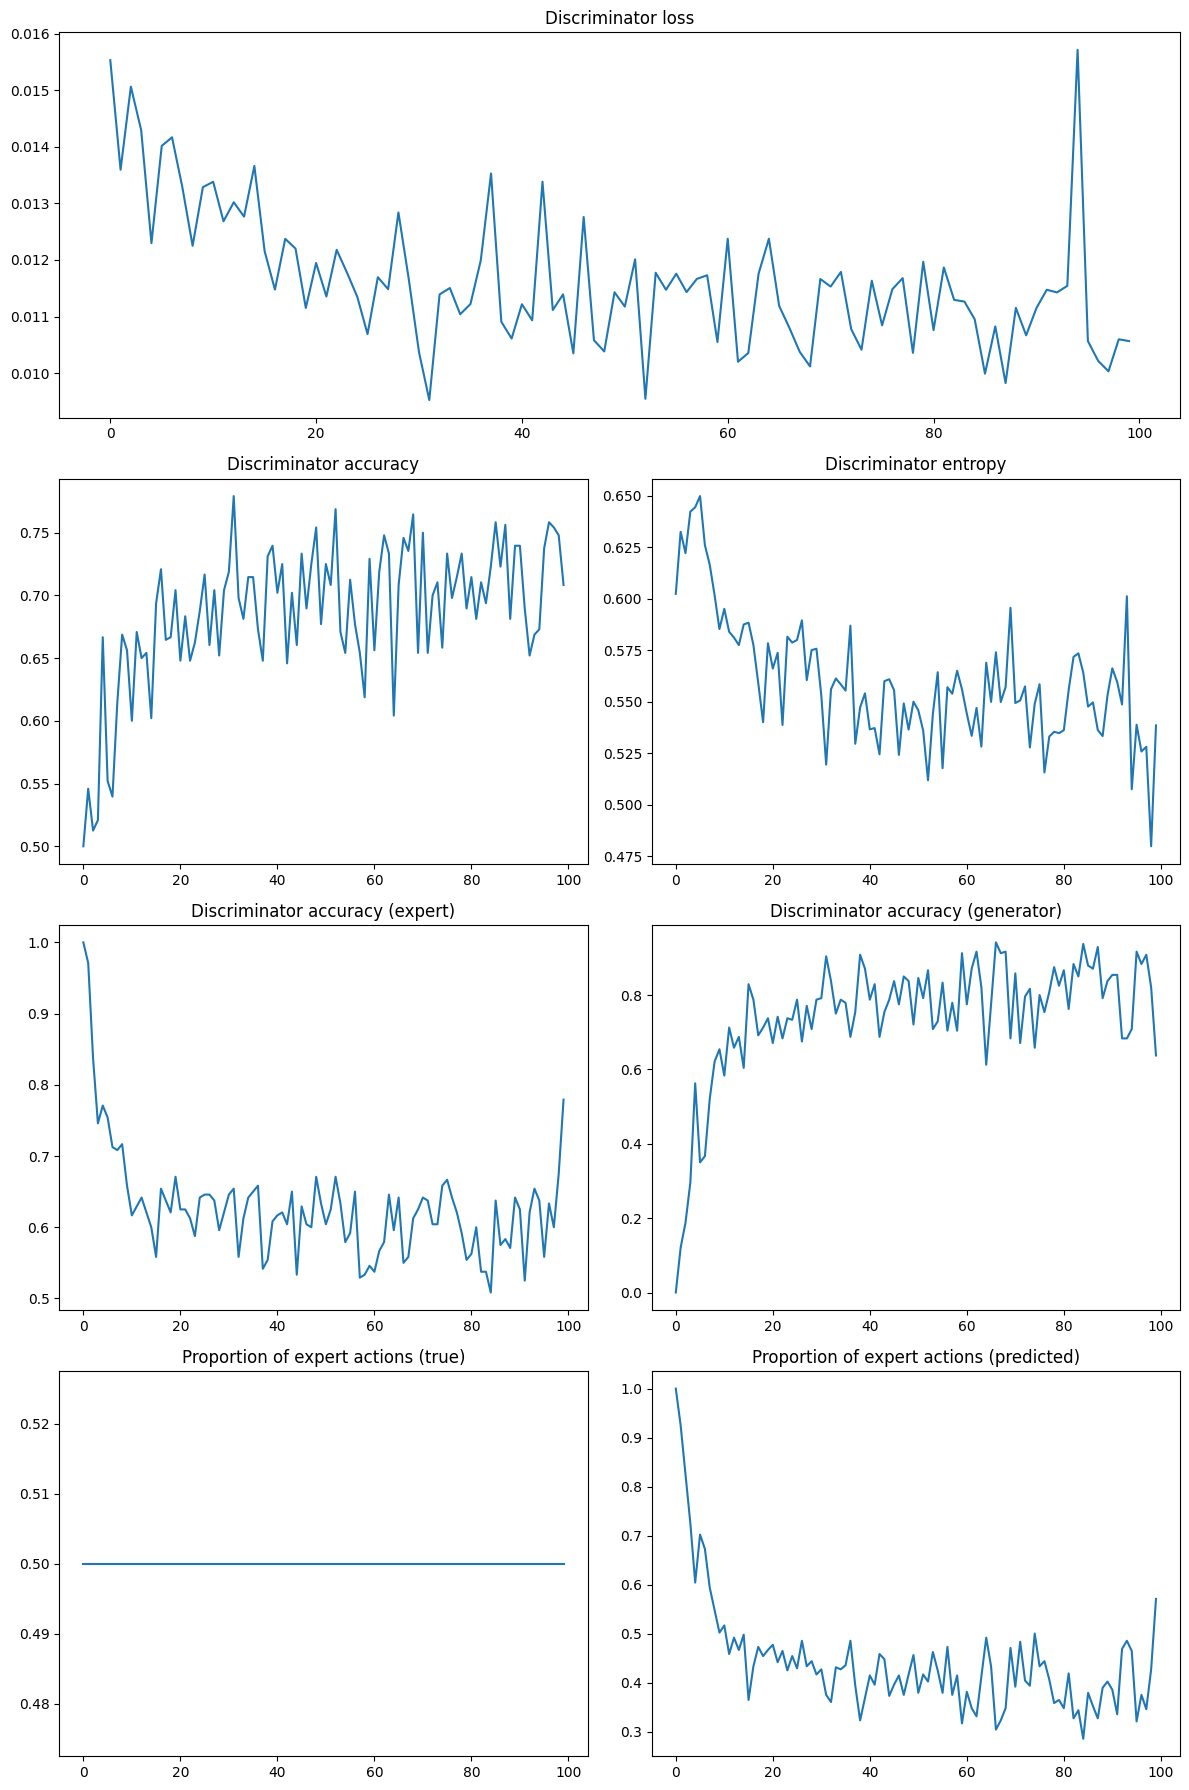

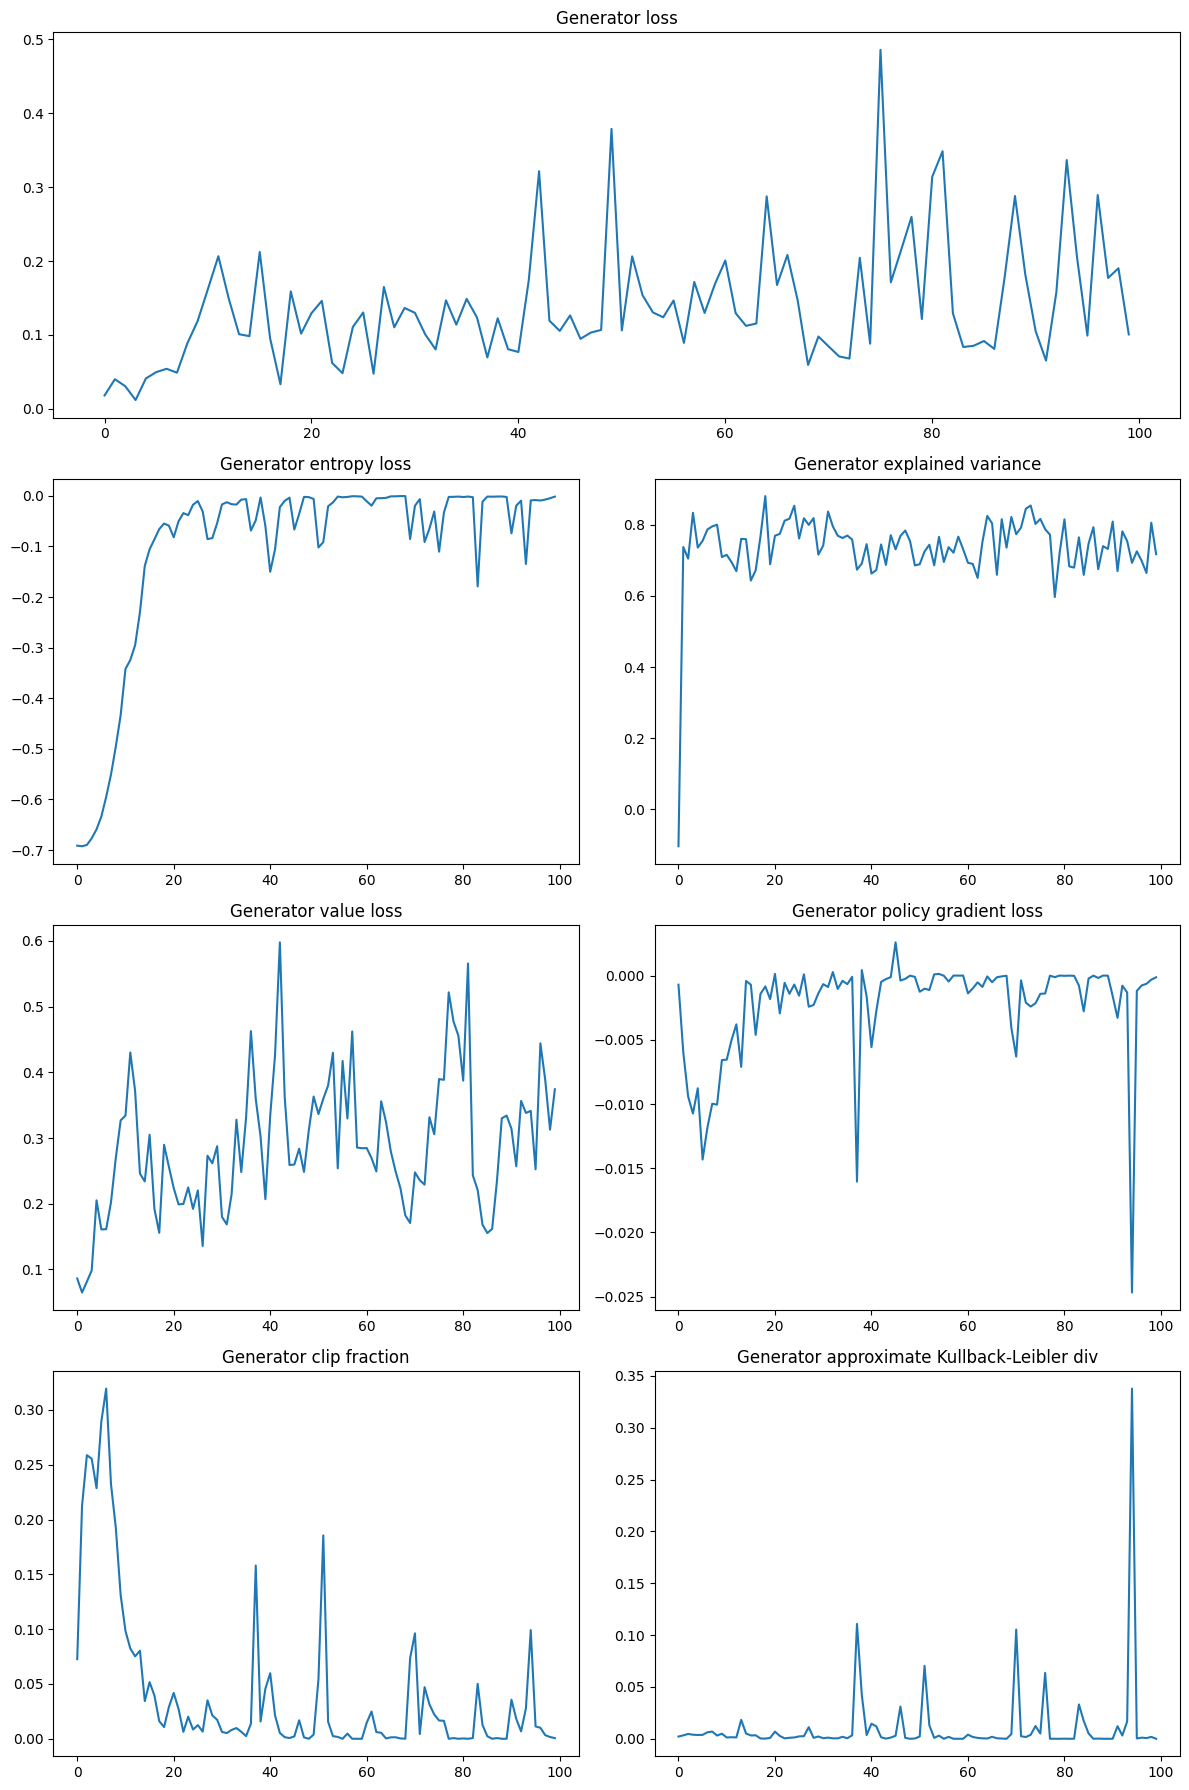

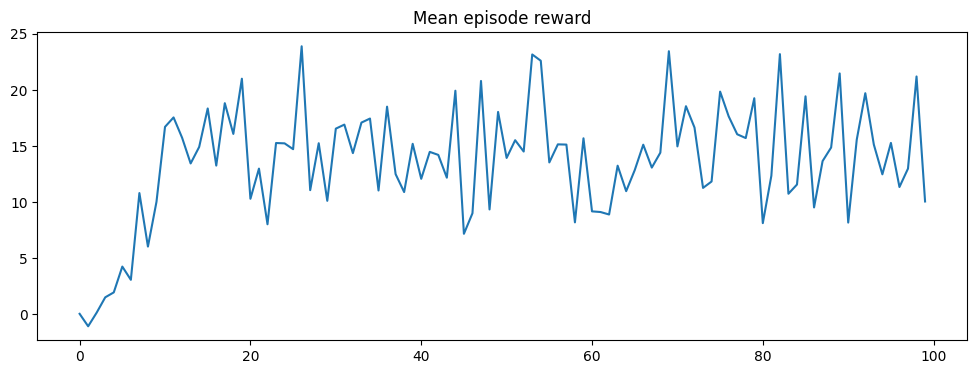

In [401]:
visualize_airl_train_stats(stats1)

In [402]:
states0, obs0, next_states0, dones0 = (
    trajectories_0_test.obs,
    trajectories_0_test.acts,
    trajectories_0_test.next_obs,
    trajectories_0_test.dones,
)
states1, obs1, next_states1, dones1 = (
    trajectories_1_test.obs,
    trajectories_1_test.acts,
    trajectories_1_test.next_obs,
    trajectories_1_test.dones,
)

In [349]:
# For reward_net1
rewards1 = reward_net1.predict(states0, obs0, next_states0, dones0)
norm_rewards1 = (rewards1 - rewards1.mean()) / rewards1.std()
print("Reward network 1 with traj0: ", norm_rewards1.mean())

# For reward_net0
rewards0 = reward_net0.predict(states0, obs0, next_states0, dones0)
norm_rewards0 = (rewards0 - rewards0.mean()) / rewards0.std()
print("Reward network 0 with traj0: ", norm_rewards0.mean())

Reward network 1 with traj0:  1.5287453e-08
Reward network 0 with traj0:  4.0129564e-08


In [350]:
# For reward_net1
rewards1 = reward_net1.predict(states1, obs1, next_states1, dones1)
norm_rewards1 = (rewards1 - rewards1.mean()) / rewards1.std()
print("Reward network 1 with traj1: ", norm_rewards1.mean())

# For reward_net0
rewards0 = reward_net0.predict(states1, obs1, next_states1, dones1)
norm_rewards0 = (rewards0 - rewards0.mean()) / rewards0.std()
print("Reward network 0 with traj1: ", norm_rewards0.mean())

Reward network 1 with traj1:  1.0056319e-08
Reward network 0 with traj1:  -6.704213e-09


Calibration

In [403]:
states, obs, next_states, dones = (
    trajectories_val.obs,
    trajectories_val.acts,
    trajectories_val.next_obs,
    trajectories_val.dones,
)

In [404]:
outputs_arb = reward_net1.predict(states, obs, next_states, dones)
outputs_nonarb = reward_net0.predict(states, obs, next_states, dones)

# Compute empirical mean and std for each network
mean_arb, std_arb = outputs_arb.mean(), outputs_arb.std()
mean_nonarb, std_nonarb = outputs_nonarb.mean(), outputs_nonarb.std()

# Define target calibration values (e.g., mean=0, std=1)
target_mean, target_std = 0.0, 1.0

# Calculate affine transformation parameters
alpha_arb = target_std / std_arb
beta_arb = target_mean - alpha_arb * mean_arb

alpha_nonarb = target_std / std_nonarb
beta_nonarb = target_mean - alpha_nonarb * mean_nonarb

# Calibrate the outputs
calibrated_arb = outputs_arb * alpha_arb + beta_arb
calibrated_nonarb = outputs_nonarb * alpha_nonarb + beta_nonarb

In [411]:
# For reward_net1
rewards1 = reward_net1.predict(states0, obs0, next_states0, dones0)
calibrated_rewards1 = alpha_arb * rewards1 + beta_arb
print("Reward network 1 with traj0: ", calibrated_rewards1.mean())

# For reward_net0
rewards0 = reward_net0.predict(states0, obs0, next_states0, dones0)
calibrated_rewards0 = alpha_nonarb * rewards0 + beta_nonarb
print("Reward network 0 with traj0: ", calibrated_rewards0.mean())

Reward network 1 with traj0:  0.033660296
Reward network 0 with traj0:  0.050710455


In [412]:
s = 0
for index, _ in enumerate(calibrated_rewards1):
    s += 1 if calibrated_rewards0[index] > calibrated_rewards1[index] else 0

print("Accuracy:", s / len(calibrated_rewards1))

Accuracy: 0.25440222428174236


In [409]:
# For reward_net1
rewards1 = reward_net1.predict(states1, obs1, next_states1, dones1)
calibrated_rewards1 = alpha_arb * rewards1 + beta_arb
print("Reward network 1 with traj1: ", calibrated_rewards1.mean())

# For reward_net0
rewards0 = reward_net0.predict(states1, obs1, next_states1, dones1)
calibrated_rewards0 = alpha_nonarb * rewards0 + beta_nonarb
print("Reward network 0 with traj1: ", calibrated_rewards0.mean())

Reward network 1 with traj1:  0.12443851
Reward network 0 with traj1:  -0.11809416


In [410]:
s = 0
for index, _ in enumerate(calibrated_rewards1):
    s += 1 if calibrated_rewards0[index] < calibrated_rewards1[index] else 0

print("Accuracy:", s / len(calibrated_rewards1))

Accuracy: 0.8532513181019332
